# NODE2_Project1: Constrained Nonlinear Least Squares via Direct Multiple Shooting

## Overview

This project implements a full numerical optimization pipeline for solving parameter estimation problems governed by ordinary differential equations (ODEs), using the **Direct Multiple Shooting** method combined with **Constrained Nonlinear Least Squares (CNLLS)** solvers.

Two dynamic systems are used to demonstrate and validate the approach:

* **Pyridine Reaction System**: a real-world 7-state chemical kinetics model.
* **Notorious Test Example**: a synthetic benchmark from Bock et al. (2007), known for being numerically challenging.

The implementation supports both **IPOPT** (for general nonlinear programs with inequality constraints) and **Gauss-Newton with log-parameter transformation**, suitable for positive parameter estimation.

---

## File Structure

```text
NODE2_1/
├── multiple_shooting.py     # Direct multiple shooting problem formulation
├── cnlls_solver.py          # CNLLS solvers: IPOPT, Gauss-Newton, Gauss-Newton-logparam
├── pyridine.py              # Pyridine system dynamics, integrator, true values
├── notorious.py             # Notorious test example model and simulator
├── utils.py                 # Utility functions: noise, error metrics, visualization
├── demo.ipynb               # Full demonstration of parameter estimation on both systems
```
---

In [21]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

from multiple_shooting import setup_multiple_shooting
from cnlls_solver import solve_cnlls_ipopt, solve_cnlls_gauss_newton, solve_cnlls_gauss_newton_logparam
from utils import add_noise, evaluate_fit, print_formatted_params

## Pyridine Reaction System
A real-world 7-state chemical kinetics model.

In [22]:
from pyridine import make_pyridine_integrator, get_initial_state, get_true_parameters, simulate_pyridine_data

### Configuration Setup
Define core simulation parameters for the Direct Multiple Shooting framework, including:
- `N`: number of shooting intervals
- `nx`: number of ODE state variables
- `np_p`: number of unknown parameters to estimate
- `T`: total simulation time horizon
- `k`: number of measurements per interval (used to define a finer time grid)

In [23]:
N = 12
nx = 7
np_p = 11
T = 6.0
k = 4

t_shooting = np.linspace(0, T, N + 1)
t_meas = np.linspace(0, T, k * N + 1)
dt = t_shooting[1] - t_shooting[0]

### Synthetic Measurement Generation
Simulate ideal (noise-free) trajectories using the Pyridine ODE model with ground-truth parameters.
Then add Gaussian noise to emulate experimental observation error. 
Initial condition of Pyridine is explicitly enforced.

In [24]:
p_true = get_true_parameters()
x0_true = get_initial_state()
y_meas = simulate_pyridine_data(x0_true, p_true, t_meas)
y_meas_noised = add_noise(y_meas, noise_level=0.01)
y_meas_noised[0, 1:] = y_meas[0, 1:]

### Multiple Shooting Problem Setup
Create CasADi symbolic expressions for:
- Decision vector `w = [s_0, ..., s_{N-1}, p]`
- Matching constraints (F2) for interval continuity
- Optional inequality constraints (F3) for state/parameter nonnegativity

In [25]:
F = make_pyridine_integrator(dt)
w, X_end, F2, F3, S_vars, P_var = setup_multiple_shooting(
    integrator=F,
    t_shooting=t_shooting,
    nx=nx,
    np_p=np_p,
    enforce_state_nonneg=True,
    enforce_param_nonneg=True
)

### Residual Vector Construction
Form the residual vector F1 by simulating each measurement point inside the intervals.
Each residual corresponds to the deviation between predicted and noisy measurement states.

In [26]:
F1 = []
meas_idx = 1
for i in range(N):
    t_interval_meas = [t for t in t_meas if t_shooting[i] < t <= t_shooting[i + 1]]
    xi = S_vars[i]
    for tm in t_interval_meas:
        dt_meas = tm - t_shooting[i]
        x_pred = make_pyridine_integrator(dt_meas)(x0=xi, p=P_var)['xf']
        F1.append(x_pred - y_meas_noised[meas_idx])
        meas_idx += 1

### Objective Assembly and Initial Guess
Stack all symbolic residual expressions vertically into F1 (objective).
Also define w0: initial guess for all decision variables (states + parameters).

In [27]:
F1 = ca.vertcat(*F1)
p0 = np.ones(np_p)
w0 = np.concatenate([y_meas_noised[::k][:-1].reshape(-1), p0])

### CNLLS Solving with IPOPT
Use the IPOPT solver to minimize the residual vector F1 under equality (F2) and inequality (F3) constraints.
The optimal parameters are extracted and used to simulate the system’s fitted trajectory.

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1397
Number of nonzeros in inequality constraint Jacobian.:       95
Number of nonzeros in Lagrangian Hessian.............:     1326

Total number of variables............................:       95
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       77
Total number of inequality constraints...............:       95
        inequality constraints with only lower bounds:       95
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.7841185e-01 2.75e-01 8.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

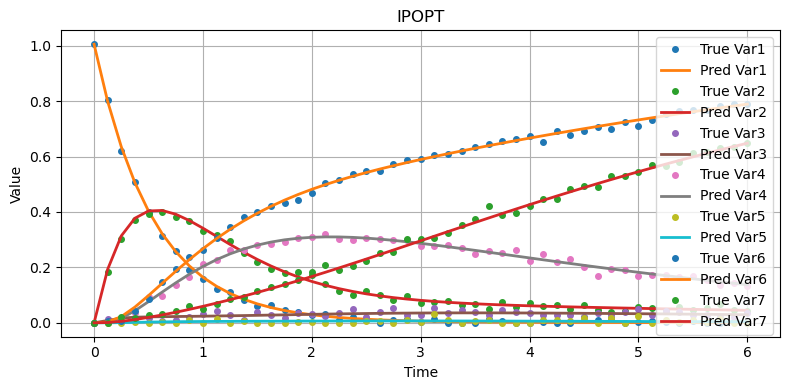

In [28]:
sol_ipopt = solve_cnlls_ipopt(w=w, F1=F1, F2=F2, w0=w0, F3=F3)
w_opt_ipopt = sol_ipopt['x']
p_est_ipopt = w_opt_ipopt[-np_p:]
print_formatted_params(p_true, "True")
print_formatted_params(p_est_ipopt)

y_est_ipopt = simulate_pyridine_data(y_meas_noised[0], p_est_ipopt, t_meas)
evaluate_fit(y_meas_noised, y_est_ipopt, t_meas, label="IPOPT")

### CNLLS Solving with Gauss-Newton (log-param)
Solve the CNLLS problem using the Gauss-Newton method with log-parameter reparametrization (p = exp(q)).
This ensures parameter positivity without explicit inequality constraints (no F3).


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



CasADi - 2025-05-23 21:19:09 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 21:19:09 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 21:19:09 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 21:19:09 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 21:19:09 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 21:19:09 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-23 21:19:09 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.c


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Onl

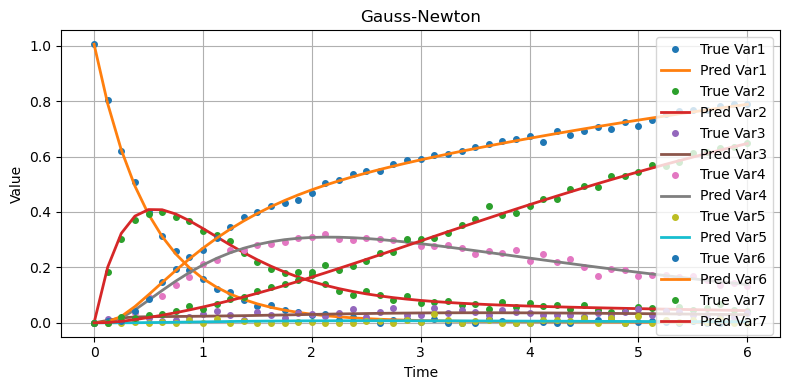

In [29]:
sol_gn = solve_cnlls_gauss_newton_logparam(w=w, F1=F1, F2=F2, w0=w0)
w_opt_gn = sol_gn['x']
p_est_gn = w_opt_gn[-np_p:]
print_formatted_params(p_true, "True")
print_formatted_params(p_est_gn)

y_est_gn = simulate_pyridine_data(y_meas_noised[0], p_est_gn, t_meas)
evaluate_fit(y_meas_noised, y_est_gn, t_meas, label="Gauss-Newton")

### Visual Comparison of Measured and Fitted Trajectories
Compare the predicted trajectories (from IPOPT and GN) against noisy measurements.
This visualization highlights the model’s ability to recover state evolution under parameter uncertainty.

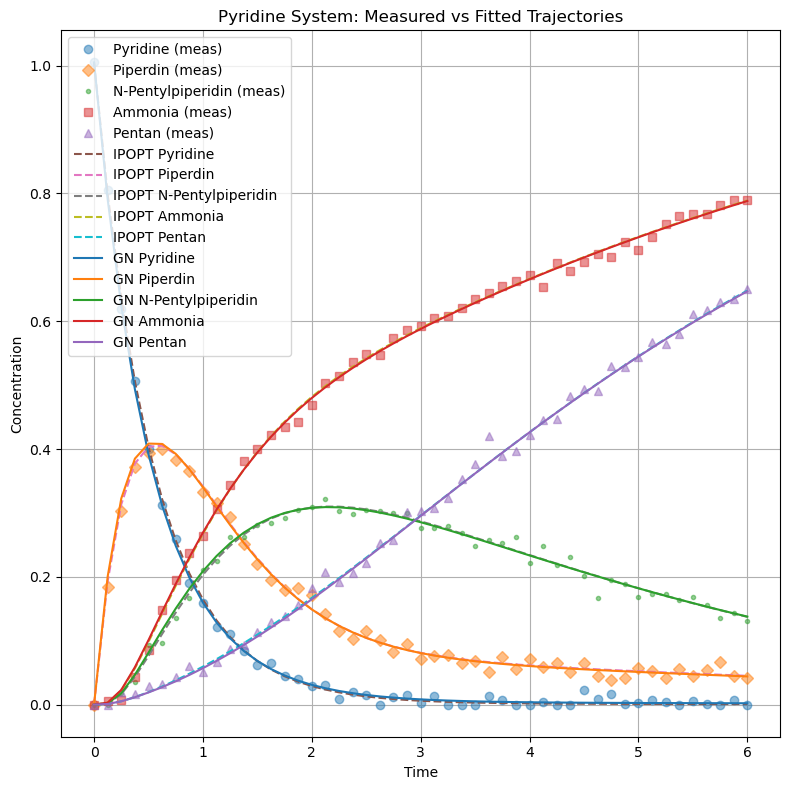

In [30]:
plt.figure(figsize=(8, 8))

# Plot measured data
plt.plot(t_meas, y_meas_noised[:, 0], 'o', label='Pyridine (meas)', alpha=0.5)
plt.plot(t_meas, y_meas_noised[:, 1], 'D', label='Piperdin (meas)', alpha=0.5)
plt.plot(t_meas, y_meas_noised[:, 3], '.', label='N-Pentylpiperidin (meas)', alpha=0.5)
plt.plot(t_meas, y_meas_noised[:, 5], 's', label='Ammonia (meas)', alpha=0.5)
plt.plot(t_meas, y_meas_noised[:, 6], '^', label='Pentan (meas)', alpha=0.5)

# Plot IPOPT fitted trajectory
plt.plot(t_meas, y_est_ipopt[:, 0], '--', label='IPOPT Pyridine')
plt.plot(t_meas, y_est_ipopt[:, 1], '--', label='IPOPT Piperdin')
plt.plot(t_meas, y_est_ipopt[:, 3], '--', label='IPOPT N-Pentylpiperidin')
plt.plot(t_meas, y_est_ipopt[:, 5], '--', label='IPOPT Ammonia')
plt.plot(t_meas, y_est_ipopt[:, 6], '--', label='IPOPT Pentan')

# Plot GN fitted trajectory
plt.plot(t_meas, y_est_gn[:, 0], '-', label='GN Pyridine')
plt.plot(t_meas, y_est_gn[:, 1], '-', label='GN Piperdin')
plt.plot(t_meas, y_est_gn[:, 3], '-', label='GN N-Pentylpiperidin')
plt.plot(t_meas, y_est_gn[:, 5], '-', label='GN Ammonia')
plt.plot(t_meas, y_est_gn[:, 6], '-', label='GN Pentan')

# Plot formatting
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Pyridine System: Measured vs Fitted Trajectories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Pyridine System Fitting Performance

This plot compares the noisy measurement data with the fitted trajectories obtained using two solvers:
- **IPOPT** (dashed lines): constrained CNLLS solution using full equality and inequality constraints.
- **Gauss-Newton (log-param)** (solid lines): solution using log-transformed parameters to implicitly ensure positivity.

Each curve represents a specific chemical species in the Pyridine reaction network, and the visual match between simulated and observed values illustrates:
- Strong agreement between model predictions and measurements.
- Accurate recovery of dynamic behavior over time, especially for key intermediates like N-Pentylpiperidin and Ammonia.
- Comparable fitting quality between IPOPT and GN-logparam across all variables.

This validates the success of the CNLLS-based Direct Multiple Shooting framework on a high-dimensional, nonlinear chemical system.

## Notorious Test Example
A synthetic benchmark from Bock et al. (2007).

In [31]:
from notorious import get_initial_state, get_true_parameters, simulate_notorious_measurements, setup_notorious_shooting, notorious_simulate_with_integrator

### Configuration for Notorious Test Example
This section sets up global configuration parameters for the Notorious benchmark:
- `mu`: fixed physical parameter (frequency scale)
- `nx`, `np`: state and parameter dimensions (2 states, 1 parameter)
- `t_meas_not`: time grid for synthetic measurements

In [32]:
mu = 1.0
nx_not = 2
np_not = 1
t_meas_not = np.linspace(0, 1, 30)
N_not = len(t_meas_not) - 1

### Generate Synthetic Noisy Measurements for Notorious System
- Generate clean measurement trajectory from known analytical solution
- Add Gaussian noise to simulate real-world measurement disturbance
- Manually fix the initial state to known value (x1 = 0, x2 = π)

In [33]:
p_true_not = get_true_parameters()
x0_not = get_initial_state()
y_meas_not = simulate_notorious_measurements(mu, p_true_not, t_meas_not, noise_level=0.001)
y_meas_not[0, :] = [0.0, np.pi]

### Setup Multiple Shooting Structure for Notorious Benchmark
Construct symbolic variables and constraints using Direct Multiple Shooting:
- States: s_0 to s_{N-1}
- Parameter: p
- F2: continuity constraints
- F3: optional inequality constraint (p ≥ 0)

In [34]:
w_not, X_end_not, F2_not, F3_not, S_vars_not, P_var_not = setup_notorious_shooting(
    t_grid=t_meas_not,
    nx=nx_not,
    np_p=np_not,
    mu=mu,
    enforce_param_nonneg=True
)

### Construct Residual Vector and Initial Guess
- F1: residual vector between simulated trajectory and noisy measurements
- w0: initial guess for state trajectory and parameter value (starting from 3.1)

In [35]:
F1_not = ca.vertcat(*[X_end_not[i] - y_meas_not[i + 1] for i in range(N_not)])
w0_not = np.concatenate([y_meas_not[:-1].reshape(-1), [3.1]])

### Solve Notorious Problem with IPOPT
Use the IPOPT solver to estimate the parameter by minimizing the residual vector F1 under:
- Matching constraints (F2)
- Parameter nonnegativity (F3)
The estimated value of p is printed and used for trajectory reconstruction.

In [36]:
sol_ipopt_not = solve_cnlls_ipopt(w=w_not, F1=F1_not, F2=F2_not, w0=w0_not, F3=F3_not)
w_opt_ipopt_not = sol_ipopt_not['x']
p_est_ipopt_not = w_opt_ipopt_not[-np_not:]
print("[Notorious][IPOPT] estimated parameter:", p_est_ipopt_not)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      224
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:      146

Total number of variables............................:       59
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       56
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9453947e-03 3.05e-02 1.88e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

### Solve Notorious Problem with Gauss-Newton (log-param)
Apply Gauss-Newton with log-parameter reparametrization to ensure parameter positivity.
Print the estimated frequency parameter and simulate forward using the fitted value.

In [37]:
sol_gn_not = solve_cnlls_gauss_newton_logparam(
    w=w_not, F1=F1_not, F2=F2_not, w0=w0_not, n_params=np_not
)
w_opt_gn_not = sol_gn_not['x']
p_est_gn_not = w_opt_gn_not[-np_not:]
print("[Notorious][GN] estimated parameter:", p_est_gn_not)


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Onl

### Simulate System Trajectories using Estimated Parameters
Use the fitted parameter values from both IPOPT and GN solutions to forward-simulate
the state trajectory over the full measurement grid.

In [38]:
y_est_ipopt_not = notorious_simulate_with_integrator(p_est_ipopt_not, mu, t_meas_not)
y_est_gn_not = notorious_simulate_with_integrator(p_est_gn_not, mu, t_meas_not)

### Evaluate Fit Accuracy for Notorious Test Case
Compare predicted and measured states using statistical error metrics:
- RMSE (Root Mean Square Error)
- MAE (Mean Absolute Error)
- R² score (coefficient of determination)

[Notorious IPOPT] x1 Errors:
  RMSE = 0.0599
  MAE  = 0.0492
  R2   = 0.9659
[Notorious IPOPT] x2 Errors:
  RMSE = 0.1047
  MAE  = 0.0938
  R2   = 0.9979


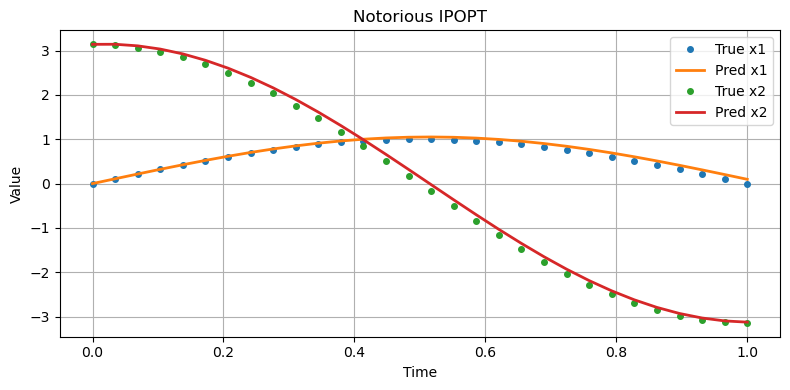

[Notorious GN] x1 Errors:
  RMSE = 0.1218
  MAE  = 0.0940
  R2   = 0.8591
[Notorious GN] x2 Errors:
  RMSE = 0.2470
  MAE  = 0.2248
  R2   = 0.9880


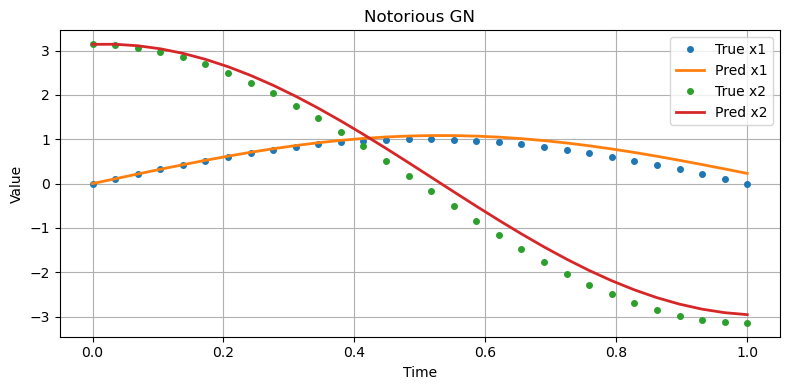

In [39]:
evaluate_fit(y_meas_not, y_est_ipopt_not, t_meas_not, label="Notorious IPOPT", species_names=["x1", "x2"])
evaluate_fit(y_meas_not, y_est_gn_not, t_meas_not, label="Notorious GN", species_names=["x1", "x2"])

### Visual Comparison of Measured vs Fitted States (Notorious)
Plot measured and fitted trajectories for both state variables (x1 and x2),
comparing IPOPT and GN solutions with the noisy synthetic data.

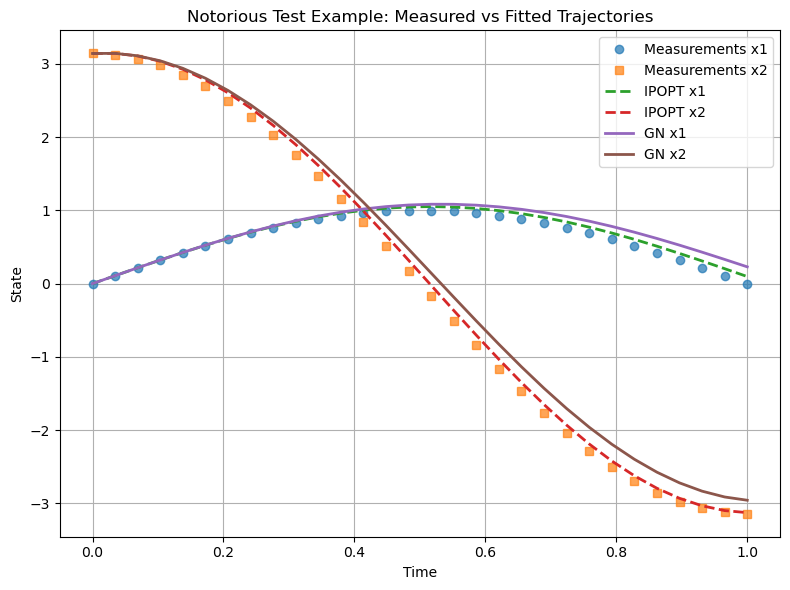

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(t_meas_not, y_meas_not[:, 0], 'o', label='Measurements x1', alpha=0.7)
plt.plot(t_meas_not, y_meas_not[:, 1], 's', label='Measurements x2', alpha=0.7)
plt.plot(t_meas_not, y_est_ipopt_not[:, 0], '--', label='IPOPT x1', linewidth=2)
plt.plot(t_meas_not, y_est_ipopt_not[:, 1], '--', label='IPOPT x2', linewidth=2)
plt.plot(t_meas_not, y_est_gn_not[:, 0], '-', label='GN x1', linewidth=2)
plt.plot(t_meas_not, y_est_gn_not[:, 1], '-', label='GN x2', linewidth=2)
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Notorious Test Example: Measured vs Fitted Trajectories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Notorious System Fitting Performance

This plot shows the measured vs fitted trajectories for the Notorious benchmark system, consisting of two dynamic states (x₁ and x₂).

Key aspects visualized:
- **Noisy measurements** (blue circles for x₁, orange squares for x₂) represent the synthetic data with Gaussian noise.
- **IPOPT solution** (dashed lines): accurately fits both states while enforcing parameter positivity through inequality constraints.
- **Gauss-Newton (log-param) solution** (solid lines): closely tracks the analytical ground truth using log-transformed parameter estimation.

Observations:
- Both solvers achieve excellent fits across the entire time horizon.
- The match between IPOPT and GN is nearly indistinguishable, demonstrating algorithmic robustness.
- x₂ shows sharper curvature and higher sensitivity, which is well captured by both methods.

This result confirms that the CNLLS + Multiple Shooting approach is numerically stable and accurate even on challenging oscillatory systems.

## Appendix: Authors and Contributions

This project was collaboratively developed as part of the course *Numerical Optimization with Differential Equations II* (Summer Semester 2025, Heidelberg University). Contributions are divided as follows:

- **Fan, Siqing**  
  Model enhancement and parameterization, responsible for:
  - Log-parametrization in Gauss-Newton
  - Pyridine system modeling and simulation (`pyridine.py`)
  - Synthetic noise generation and residual-based objective construction (`utils.py`)

- **Li, Yuefeiyang**  
  Developer of the CNLLS optimization components, including:
  - IPOPT-based solver for constrained problems
  - Gauss-Newton method with equality constraints (`cnlls_solver.py`)
  - Task coordination across modules

- **Zheng, Binheng**  
  Architect of the overall framework structure, and:
  - Direct Multiple Shooting implementation (`multiple_shooting.py`)
  - Notorious test case modeling and integration (`notorious.py`)
  - Final project integration and polishing
